***Simen Håpnes***

# Regression problem: Forced Vital Capacity

A data set contains 24 predictors, 496 data points and 1 continuous output: forced vital capacity. This is a regression problem, because the output values are continuous. The data will be analyzed with various machine learning methods in Python.

## Processing the data set
In the code below, the data set is processed:
1. The data set is split into training and test sets with a 50/50 split (248 data points in each subset).
2. The continuous and categorical values are identified.
3. All predictors are standardized (mean=0, std=1). Both the training set and the test set are scaled according to the training set: that way the training set contains no information from the test set, and both sets are scaled in the fashion that the ML methods are "trained for".


In [43]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 10]

# Read data file
df = pd.read_csv("./data/ozone_496obs_25vars.txt", sep=" ")
names = list(df) # list of all predictor names
predictor_list = names[:-1]

# Split of training and test
train_df, test_df = train_test_split(df, test_size=0.5, random_state=42)
N_train = len(train_df.index)
N_test = len(test_df.index)

# These columns only contains binary values (0 or 1)
categorcal_indices = [1, 2, 3, 4, 5, 6, 7, 9, 13, 14, 17, 19, 20, 22, 23]
# These columns contains continuous variables
continuous_indices = [0, 8, 10, 11, 12, 15, 16, 18, 21, 24]
categorcal_names = []
continuous_names = []

for i in range(25):
    if i in categorcal_indices:
        categorcal_names.append(names[i]) # Save these names for later
    else:
        continuous_names.append(names[i]) # Save these names for later


# Scaling of columns
# Scale columns so that mean=0, std=1
scl = StandardScaler(with_mean=True, with_std=True)
# Scale both the train/test according to training set:
scl.fit(train_df) 
train_df = pd.DataFrame(scl.transform(train_df), columns=names)
test_df = pd.DataFrame(scl.transform(test_df), columns=names)

X_train = train_df.loc[:, train_df.columns != "FFVC"]
y_train = train_df["FFVC"]
X_test = test_df.loc[:, test_df.columns != "FFVC"]
y_test = test_df["FFVC"]

The categorical values are **not** one-hot encoded, and my choice of this has a few reasons:
1. All categorical values are binary (0 or 1), if there was more than two categories, it is a necessity to one-hot encode these columns in order to separate the categories.
2. I choose to scale the categorical columns, so that they become, say -0.8 and +0.2 (if 80% of the values were zeros). I chose the scaling because we are going to use linear regression models, which can only model each predictor with a single weight (scalar). 
    * If they were not scaled, there is no coefficient which can model the zeros for a categorical predictor, but now a coefficient can model a tendency towards both categories in a predictor.
    * When every predictor is scaled, I don't need to include a bias term, because the data is centered already.

Now would be a good time to look at the processed data:

In [88]:
# Produce some nice prints which analyze the processed data

print(f"\tTrain data: {N_train} data points")
print(f"\tTest data: {N_test} data points\n")

print("\tContinuous columns.")
print("\tCovariant  Train mean  Train std  Test mean  Test std")
print("\t-----------------------------------------------------")
for name in predictor_list:
    if name in continuous_names:
        tr_mean = np.mean(X_train[name])
        tr_std = np.std(X_train[name])
        te_mean = np.mean(X_test[name])
        te_std = np.std(X_test[name])
        print(f"\t{name:10} {tr_mean:10.2e} {tr_std:10.2f}", end="")
        print(f" {te_mean:10.2e} {te_std:9.2f}")

print("\n\tCategorical columns")
print("\tCovariant  Train ones  Train zeros  Test ones  Test zeros | Imbalance")
print("\t----------------------------------------------------------|----------")
for name in predictor_list:
    if name in categorcal_names:
        tr_ones = int(np.sum(train_df[name].values > 0))
        tr_zeros = int(N_train - tr_ones)
        te_ones = int(np.sum(test_df[name].values > 0))
        te_zeros = int(N_test - te_ones)
        print(f"\t{name:10} {tr_ones:10}  ",  end="")
        print(f" {tr_zeros:10} {te_ones:10} {te_zeros:11}", end="")
        print(f" |{tr_ones/(tr_ones+te_ones):10.2f}")

	Train data: 248 data points
	Test data: 248 data points

	Continuous columns.
	Covariant  Train mean  Train std  Test mean  Test std
	-----------------------------------------------------
	ALTER       -8.07e-16       1.00   1.68e-02      1.03
	AGEBGEW      2.72e-16       1.00  -4.04e-03      0.95
	FLGROSS      1.92e-15       1.00  -4.68e-02      1.04
	FMILB        3.42e-16       1.00   5.66e-02      1.05
	FNOH24      -5.55e-17       1.00   1.77e-01      1.11
	FLTOTMED     6.72e-17       1.00  -2.48e-01      0.60
	FO3H24       5.81e-17       1.00  -1.70e-02      0.97
	FTEH24      -4.77e-17       1.00   3.59e-02      0.97
	FLGEW       -3.19e-16       1.00   1.75e-02      0.99

	Categorical columns
	Covariant  Train ones  Train zeros  Test ones  Test zeros | Imbalance
	----------------------------------------------------------|----------
	ADHEU              19          229         18         230 |      0.51
	SEX               134          114        117         131 |      0.53
	HOCHOZON 

Two remarks regarding the processed data:
1. Continuous predictors: The test set is scaled according to the training set, therefore the mean/std values in the training set is very close to mean=0 and std=1. For the test set however, the **mean/std** is not as close to **0/1** as in the training set. This is as expected.
2. Categorical predictors: The number of ones in the train and test set are very good distributed (the imbalance is at worst a split of 61% and 39%, when the goal is of course a 50/50 split for most variables).

## Linear Gaussian Regression

First, I define a function which can plot a bar-plot of the coeff., std. err. and p-values, because this is something I will do multiple times:

In [45]:
def plot_coeff_stderr_pvalues(results, X, title):
    """A function that take the result object, X-matrix and a plot title
    It will plot a bar plot of:
     * Coeff
     * std. err.
     * P-values
     
    for the variables in the X matrix
    """
    data = {
        "Coeff.": results.params,
        "Std. Err.": results.bse,
        "p-value": results.pvalues
    }
    dataFrame = pd.DataFrame(data=data)
    dataFrame.index = list(X)
    dataFrame.plot.barh(title= title)
    plt.show()
    
def mse_func(y, y_pred):
    """Compute the MSE"""
    return np.mean((y - y_pred)**2)

def r2_func(y, y_pred):
    """Compute the R2 score"""
    y_mean = np.mean(y)
    RSS = np.sum((y - y_pred) ** 2)  # residual sum of squares
    TSS = np.sum((y - y_mean) ** 2)  # total sum of squares
    return (1 - RSS / TSS)

def print_mse_and_r2(y, y_pred, string):
    """Print both MSE and R2"""
    MSE = mse_func(y, y_pred)
    R2 = r2_func(y, y_pred)
    print(string + f": MSE = {MSE:1.4f}, R2 = {R2:1.4f}")

The ordinary least squares is a method which can be quickly performed by a function from the statsmodels package:

Training set: MSE = 0.3139, R2 = 0.6861
Testing set: MSE = 0.4356, R2 = 0.6044


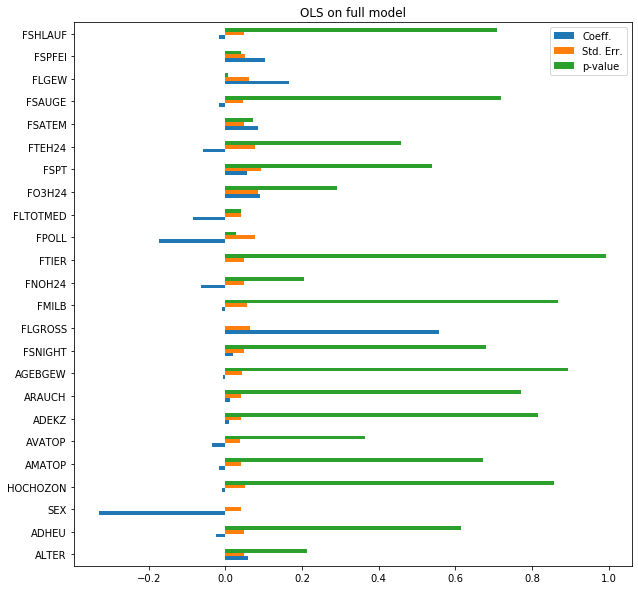

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.686
Model:                            OLS   Adj. R-squared (uncentered):              0.652
Method:                 Least Squares   F-statistic:                              20.40
Date:                Tue, 19 Nov 2019   Prob (F-statistic):                    1.12e-43
Time:                        10:42:10   Log-Likelihood:                         -208.22
No. Observations:                 248   AIC:                                      464.4
Df Residuals:                     224   BIC:                                      548.8
Df Model:                          24                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [46]:
X = X_train.copy()
y = y_train.copy().values
Xt = X_test.copy()
yt = y_test.copy().values

model = sm.OLS(y, X) # Ordinary least squares
results = model.fit() # fit model

# Evaluate MSE/R2 on the training set
y_pred = results.predict(X)
print_mse_and_r2(y, y_pred, "Training set")

# Evaluate MSE/R2 on the test set
y_pred = results.predict(Xt)
print_mse_and_r2(yt, y_pred, "Testing set")

# Call the plot function
plot_coeff_stderr_pvalues(results, X_train, "OLS on full model")

# Print a summary of the results
print(results.summary())

The covariate with the strongest association (largest absolute value of coefficient) to FFVC is:
* FLGROSS (height in cm at lufu), with a coefficient of 0.5558 and the lowest P-value (<0.0005).

The covariate with the weakest association is 
* AGEBGEW (weight at birth)

The P-values vary a lot, and some of the predictors with the smallest P-values are SEX, FLTOTMED, FSATEM and FSPFEI.

Most std. errors vary in the range $[0.04, 0.08]$ and:
* The predictor with the lowest std. err. is AVATOP.
* The predictor with the highest std. err. is FSPT.

## Reduced models by forward selection and backward elimination

First I will create the functions which performs these model reductions given a general stopping criterion:

In [50]:
def backward_elimination(X, y, Xt, yt, p_stop_crit):
    p = p_stop_crit + 1
    iter = 0
    max_iter = len(list(X))
    X_temp = X.copy()
    while p > p_stop_crit and iter <= max_iter:
        iter += 1
        results = sm.OLS(y, X_temp).fit()
        # find covariate with largest p-value:
        covariate = np.argmax(results.pvalues)
        p = np.max(results.pvalues)
        # remove covariate from X before next iteration
        if p > p_stop_crit: # If stopping criterion is reached, keep X as it is, 
            del X_temp[covariate] # Reduce X_temp before next iteration
    
    
    # Evaluate MSE/R2 on training set
    model = sm.OLS(y, X_temp) 
    results = model.fit()
    y_pred = results.predict(X[list(X_temp)]) # training (predictors subset)
    print_mse_and_r2(y, y_pred, "Training set")
    
    # Evaluate MSE/R2 on test set
    y_pred = results.predict(Xt[list(X_temp)]) # test (predictors subset)
    print_mse_and_r2(yt, y_pred, "Testing set")
    
    # Bar plot
    plot_coeff_stderr_pvalues(results, X_temp,
        f"Backward Elimination, p > {p_stop_crit:2.2f} removed.")
    
    # Summary print
    print(results.summary())


def forward_selection(X, y, Xt, yt, p_stop_crit):
    max_p = 0
    iter = len(list(X))
    final_model = pd.DataFrame() # empty model to begin with
    X_temp = X.copy()

    while max_p < p_stop_crit and iter > 0:
        iter -= 1
        least_p_value = 10 # arbitrary large number (needed for the if test below)
        for cov in list(X_temp):
            temp_model = final_model # temporary final model (which will be built up)
            temp_model[cov] = X_temp[cov] # Add one covariate
            # Evaluate p
            results = sm.OLS(y, temp_model).fit()
            temp_p = np.min(results.pvalues[-1])
            # Check if p is the least obtained p so far:
            if temp_p < least_p_value:
                least_cov = cov
                least_p_value = temp_p
                new_col = temp_model[cov]
            # Reset temporary model
            del temp_model[cov]
            
        # max p now:
        final_model = pd.concat([final_model, X_temp[least_cov]], axis=1)
        results = sm.OLS(y, final_model).fit()
        max_p = np.max(results.pvalues)
        
        # Remove covariate from X_temp before next iteration, because this cov
        # has already been added to the final model
        del X_temp[least_cov]

    # Evaluate MSE/R2 on training set
    model = sm.OLS(y, final_model) 
    results = model.fit()
    y_pred = results.predict(X[list(final_model)]) # training (predictors subset)
    print_mse_and_r2(y, y_pred, "Training set")
    
    # Evaluate MSE/R2 on test set
    y_pred = results.predict(Xt[list(final_model)]) # test (predictors subset)
    print_mse_and_r2(yt, y_pred, "Testing set")
    
    # Bar plot
    plot_coeff_stderr_pvalues(results, final_model,
        f"Forward Selection, p < {p_stop_crit:2.2f} included.")
    
    # Summary print
    print(results.summary())

### **First Criterion**: Only include $p < 0.05$, 
first with backward elimination:

Training set: MSE = 0.3249, R2 = 0.6751
Testing set: MSE = 0.4330, R2 = 0.6068


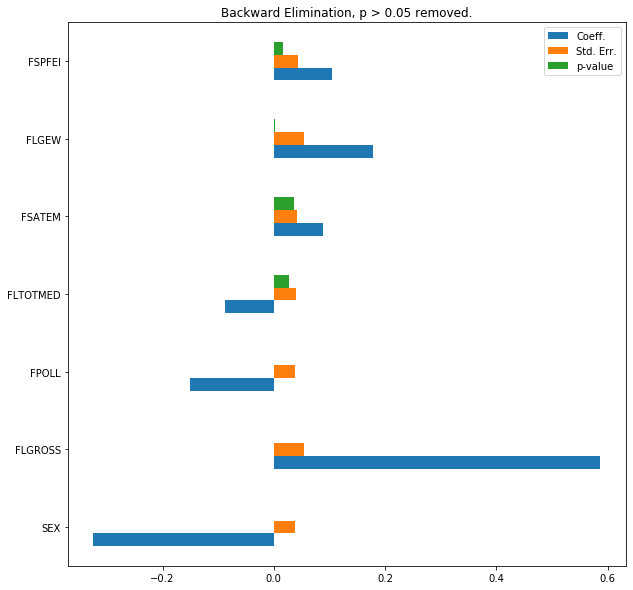

                                 OLS Regression Results                                
Dep. Variable:                   FFVC   R-squared (uncentered):                   0.675
Model:                            OLS   Adj. R-squared (uncentered):              0.666
Method:                 Least Squares   F-statistic:                              71.55
Date:                Tue, 19 Nov 2019   Prob (F-statistic):                    2.71e-55
Time:                        10:47:12   Log-Likelihood:                         -212.47
No. Observations:                 248   AIC:                                      438.9
Df Residuals:                     241   BIC:                                      463.5
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [51]:
backward_elimination(X_train, y_train, X_test, y_test, 0.05)

Now with forward selection:

Training set: MSE = 0.3308, R2 = 0.6692
Testing set: MSE = 0.4319, R2 = 0.6077


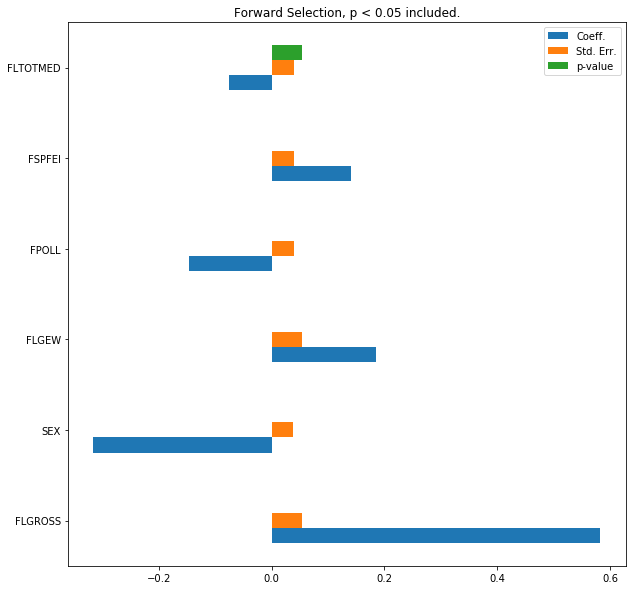

                                 OLS Regression Results                                
Dep. Variable:                   FFVC   R-squared (uncentered):                   0.669
Model:                            OLS   Adj. R-squared (uncentered):              0.661
Method:                 Least Squares   F-statistic:                              81.60
Date:                Tue, 19 Nov 2019   Prob (F-statistic):                    2.47e-55
Time:                        10:47:38   Log-Likelihood:                         -214.71
No. Observations:                 248   AIC:                                      441.4
Df Residuals:                     242   BIC:                                      462.5
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [52]:
forward_selection(X_train, y_train, X_test, y_test, 0.05)

### New stopping criterion $p < 0.20$:

Training set: MSE = 0.3193, R2 = 0.6807
Testing set: MSE = 0.4300, R2 = 0.6095


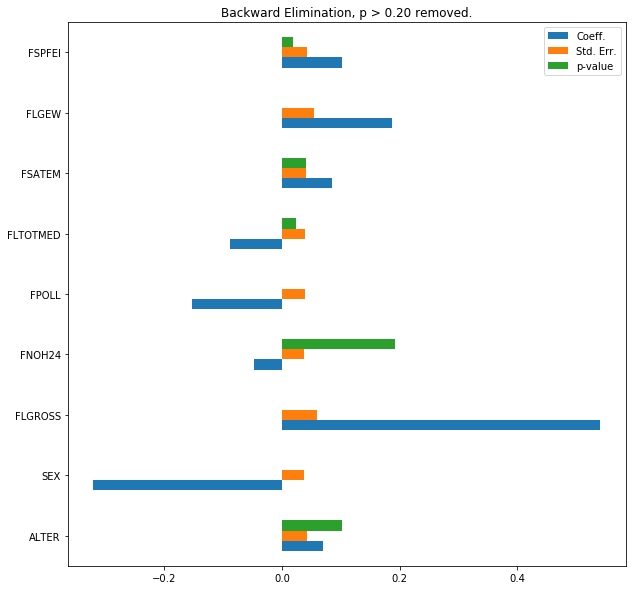

                                 OLS Regression Results                                
Dep. Variable:                   FFVC   R-squared (uncentered):                   0.681
Model:                            OLS   Adj. R-squared (uncentered):              0.669
Method:                 Least Squares   F-statistic:                              56.61
Date:                Tue, 19 Nov 2019   Prob (F-statistic):                    2.55e-54
Time:                        10:47:55   Log-Likelihood:                         -210.33
No. Observations:                 248   AIC:                                      438.7
Df Residuals:                     239   BIC:                                      470.3
Df Model:                           9                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [53]:
backward_elimination(X_train, y_train, X_test, y_test, 0.20)

Training set: MSE = 0.3181, R2 = 0.6819
Testing set: MSE = 0.4359, R2 = 0.6041


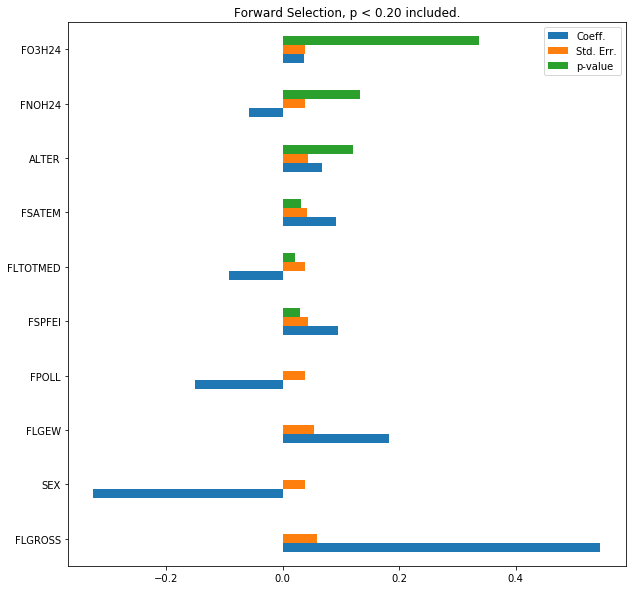

                                 OLS Regression Results                                
Dep. Variable:                   FFVC   R-squared (uncentered):                   0.682
Model:                            OLS   Adj. R-squared (uncentered):              0.669
Method:                 Least Squares   F-statistic:                              51.03
Date:                Tue, 19 Nov 2019   Prob (F-statistic):                    1.26e-53
Time:                        10:48:14   Log-Likelihood:                         -209.85
No. Observations:                 248   AIC:                                      439.7
Df Residuals:                     238   BIC:                                      474.8
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [54]:
forward_selection(X_train, y_train, X_test, y_test, 0.20)

The two methods does not yield the same result:
* With the first stopping criterion (p<0.05), backward elimination includes one more predictor (FSATEM) than forward selection. This is very possible outcome due to the difference in the methods.
* With the second stopping criterion (p<0.20), forward selection includes one more predictor than backward elimination.

I would expect that these methods might perform better than the full model, because with 24 predictors might be a too high model complexity for this data set and therefore overfitting (high variance) will occur. Another possibility is that the model is not complex enough or contains irrelevant predictors, and then the model will exhibit underfitting (high bias). It is hard to tell whether the model will overfit or underfit the data before looking at the results. 

My expectations are one thing, and the results are another. *The reduced models achieve very similar results as of the full model* (similar train and test errors, but also similar R2 scores). This means that the reduced models probably underfitted the data, this should result in larger test errors, which was not observed. However, this could be a result of a small data set.

## LASSO regression with k-fold CV and bootstrap



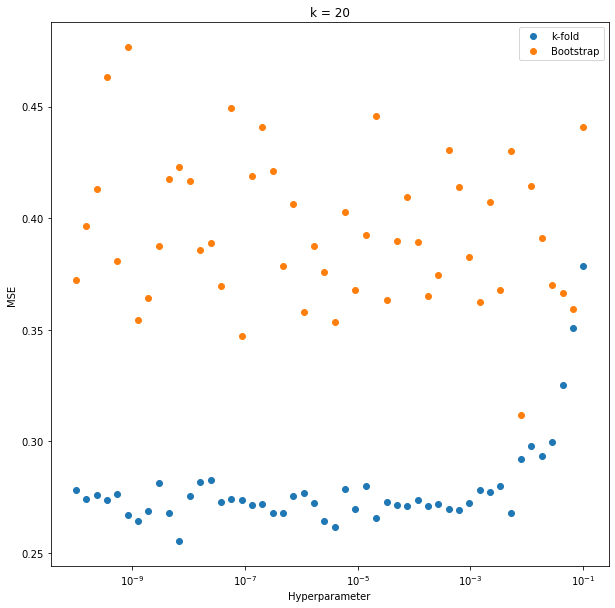

Best alpha = 4.095e-04
Training set: MSE = 0.3176, R2 = 0.5012
Test set: MSE = 0.4370, R2 = 0.3620


In [95]:
from sklearn.linear_model import Lasso
from math import floor

class LassoRegr:
    """
    Simple Class for LASSO
    Example:
    obj = LassoRegr(X, y)
    MSE, R2 = obj.k_fold_CV(
        k=10, 
        alpha=1e-5, 
        bootstrap=False
    )
    """
    def __init__(self, X, y):
        # store all of X, y
        self.X = X
        self.y = y
        # copies of X, y (used in CV)
        self.X_temp = X
        self.y_temp = y

    def fit(self, alpha=1e-6):
        model = Lasso(alpha=alpha)
        model.fit(self.X_temp, self.y_temp)
        p = self.X_temp.shape[1]
        self.beta = np.transpose(model.coef_)
        self.beta[0] = model.intercept_
        self.p = self.beta.shape[0]
        return None

    def predict(self, X):
        y_pred = X @ self.beta
        return y_pred
            
    def k_fold_CV(self, k, alpha, bootstrap=False):
        mse = np.zeros(k)
        r2 = np.zeros(k)
        N = self.X.shape[0]
        p = np.random.permutation(N)  # permutation array for shuffling of data
        length = floor(N / k)  # number of indices per interval k.
        for i in range(k):
            
            # Bootstrap: choose a random subset of the data
            if bootstrap: 
                entire_set = np.random.permutation(N)
                train_set = entire_set[length:]
                test_set = entire_set[:length]
                
            # K-fold: choose subsets of the data in a cyclic fashion
            else:
                start = i * length
                stop = (i + 1) * length
                train_set = np.concatenate((p[:stop], p[start:]))
                test_set = p[start:stop]
                
            # split
            X_test = self.X[test_set]
            y_test = self.y[test_set]
            self.X_temp = self.X[train_set]
            self.y_temp = self.y[train_set]
            
            # fit
            self.fit(alpha=alpha)
            
            # predict
            y_pred = self.predict(X_test)
            
            # evaluate
            mse[i] = mse_func(y_test, y_pred)
            r2[i] = r2_func(y_test, y_pred)

        # Reset temporary arrays
        self.X_temp = self.X
        self.y_temp = self.y
        
        # Evaluate mean
        MSE = np.mean(mse)
        R2 = np.mean(r2)
        
        return MSE, R2
    
    
# Compute results by using the LassoRegr-class:
X = X_train.copy().values
Xt = X_test.copy().values
y = y_train.copy().values
yt = y_test.copy().values


n_alphas = 50
n_folds = 20

# alpha array
alphas = np.logspace(-10, -1, n_alphas)

# arrays to store the results in
kfold_mse = np.zeros(n_alphas)
bootstrap_mse = np.zeros(n_alphas)

# Loop through alphas and Cross validate
reg = LassoRegr(X, y)
for i,alpha in enumerate(alphas):
    
    # k-fold
    mse, r2 = reg.k_fold_CV(n_folds, alpha, bootstrap=False)
    kfold_mse[i] = mse
    
    # bootstrap
    mse, r2 = reg.k_fold_CV(n_folds, alpha, bootstrap=True)
    bootstrap_mse[i] = mse
    
    
# Plot MSEs vs. alpha for both methods
plt.title(f"k = {n_folds}")
plt.semilogx(alphas, kfold_mse, "o", label="k-fold")
plt.semilogx(alphas, bootstrap_mse, "o", label="Bootstrap")
plt.legend()
plt.ylabel("MSE")
plt.xlabel("Hyperparameter")
plt.show()

# Prints
kfold_idx = np.argmax(kfold_scores)
kfold_alpha = alphas[kfold_idx]
bootstrap_idx = np.argmax(bootstrap_scores)
bootstrap_alpha = alphas[bootstrap_idx]
alpha = np.min([kfold_alpha, bootstrap_alpha])

# Print best alpha LASSO regression
print(f"Best alpha = {alpha:1.3e}")
reg = LassoRegr(X, y)
reg.fit(alpha=kfold_alpha)
y_pred = reg.predict(X)
print_mse_and_r2(y_pred, y, "Training set")
y_pred = reg.predict(Xt)
print_mse_and_r2(y_pred, yt, "Test set")

As can be seen in the figure, k-fold CV provides more stable estimates of MSE for the various regularization parameters. Bootstrap is much more dominated by stochasticity and have very varying results.

## General additive model (1) and linear regression with polynomial features (2)


Training set: MSE = 0.2712, R2 = 0.7288
Test set: MSE = 0.4343, R2 = 0.6055


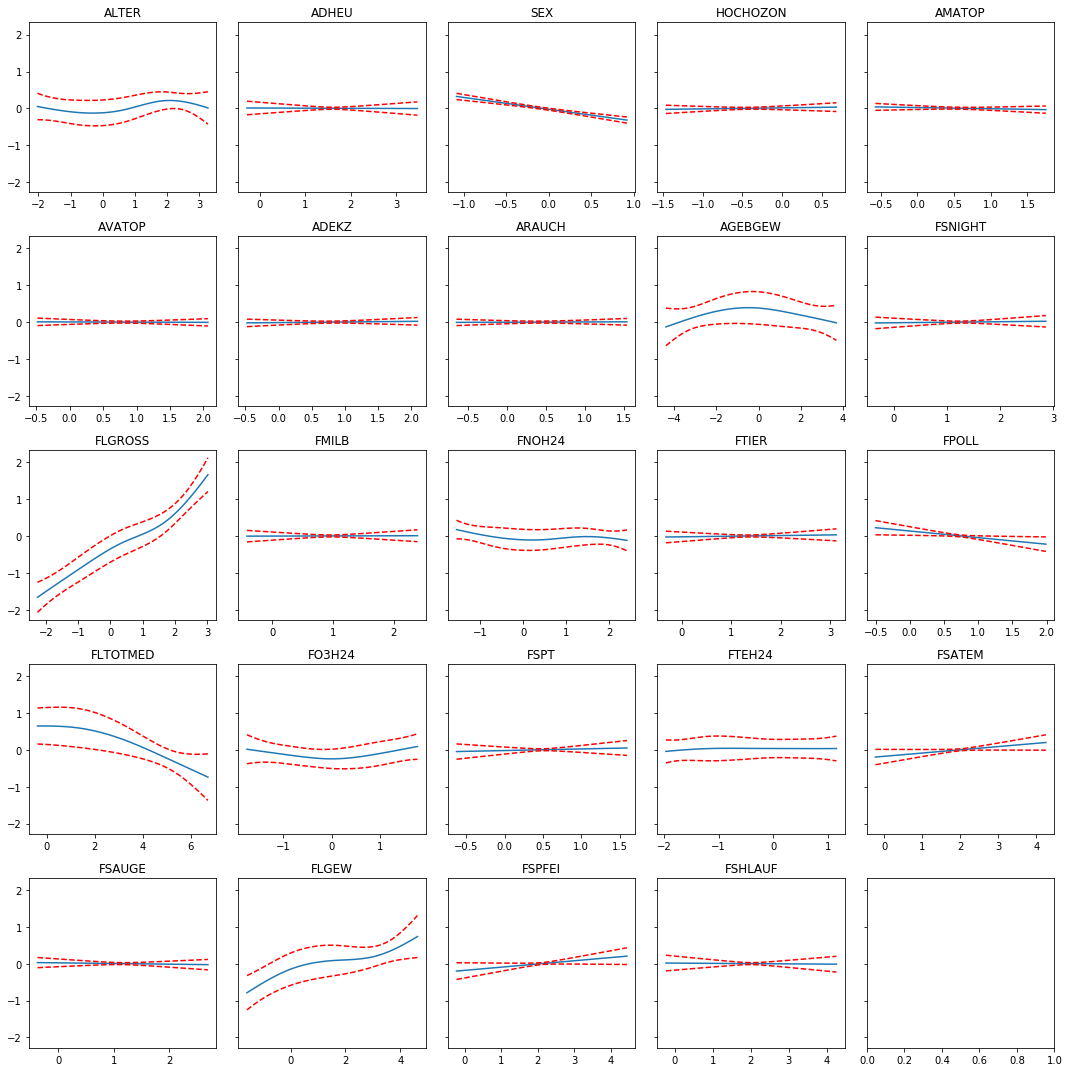

In [69]:
from pygam import LinearGAM, s, l

X = X_train.copy()
y = y_train.copy()
Xt = X_test.copy()
yt = y_test.copy()
gam = LinearGAM(n_splines=7).fit(X, y)
y_pred = gam.predict(X)
print_mse_and_r2(y, y_pred, "Training set")
y_pred = gam.predict(Xt)
print_mse_and_r2(yt, y_pred, "Test set")

# Create a plot which plots all the variables (with 0.95 confidence interval)
fig, axes = plt.subplots(5, 5, sharey=True, figsize=[15, 15])
axes = axes.ravel()
for i,feat in enumerate(list(X)):
    XX = gam.generate_X_grid(term=i) # Generate a X grid
    axes[i].plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
    axes[i].plot(XX[:, i], gam.partial_dependence(term=i, X=XX, width=.95)[1], c='r', ls="--")
    axes[i].set_title(feat)
    
fig.tight_layout()
plt.show()

# by inspection of figure, these predictors look non-linear (the categorical are left undetermined)
non_linear_predictors = ["ALTER", "AGEBGEW", "FO3H24", "FLTOTMED", "FLGEW"] 
non_linear_idx = [0, 8, 12, 18, 21]
linear_predictors = []
for feat in list(X):
    if feat not in non_linear_predictors:
        linear_predictors.append(feat)

In [71]:
Xt = X_test.copy()
yt = y_test.copy()

# Add polynomial (2nd. degree) terms for the non-linear terms
for feat in non_linear_predictors:
    X[feat + "^2"] = X[feat].copy()**2
    Xt[feat + "^2"] = Xt[feat].copy()**2

model = sm.OLS(y, X)
results = model.fit() # fit new model

# Evaluate MSE/R2 on the training set
y_pred = results.predict(X)
print(y.values.reshape(-1).shape, y_pred.shape)
print_mse_and_r2(y.values.reshape(-1), y_pred, "Training set")
y_pred = results.predict(Xt)
print_mse_and_r2(yt.values.reshape(-1), y_pred, "Test set")

(248,) (248,)
Training set: MSE = 0.2974, R2 = 0.7026
Test set: MSE = 0.4478, R2 = 0.5933


## Boosting
The task is two use boosting with three base learners:
1. Linear model
2. Splines
3. Trees

However, I could not find any way to use splines for this problem, so only 1. and 3. will be implemented.

In [81]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

X = X_train.copy()
Xt = X_test.copy()
y = y_train.copy()
yt = y_test.copy()

print("Boosting with linear regressor")
reg = AdaBoostRegressor(base_estimator = LinearRegression())
reg.fit(X, y)
y_pred = reg.predict(X)
print_mse_and_r2(y, y_pred, "Training set")
y_pred = reg.predict(Xt)
print_mse_and_r2(yt, y_pred, "Test set")

print("Boosting with decision trees")
reg2 = AdaBoostRegressor(base_estimator = DecisionTreeRegressor(), n_estimators=500) 
reg2.fit(X, y)
y_pred = reg2.predict(X)
print_mse_and_r2(y, y_pred, "Training set")
y_pred = reg2.predict(Xt)
print_mse_and_r2(yt, y_pred, "Test set")

Boosting with linear regressor
Training set: MSE = 0.3053, R2 = 0.6947
Test set: MSE = 0.4622, R2 = 0.5802
Boosting with decision trees
Training set: MSE = 0.0005, R2 = 0.9995
Test set: MSE = 0.4957, R2 = 0.5498


## Train and test error for all models
In the table below, all train and test errors are shown for comparisson.

| Model                              | Train error | Test error |
|------------------------------------|-------------|------------|
| Full Linear model                  | 0.3139      | 0.4356     |
| Backward elimination (p<0.05)      | 0.3249      | 0.4330     |
| Forward selection (p<0.05)         | 0.3308      | 0.4319     |
| Backward elimination (p<0.20)      | 0.3193      | 0.4306     |
| Forward selection (p<0.20)         | 0.3181      | 0.4359     |
| LASSO regression                   | 0.3176      | 0.4370     |
| GAM with splines                   | 0.2712      | 0.4343     |
| Linear model with polynomial terms | 0.2974      | 0.4478     |
| Boosting with linear regression    | 0.3275      | 0.4576     |
| Boosting with decision trees       | 0.0005      | 0.4957     |


Remarks:
* Backward elimination (p<0.20) performs best in terms of test error by a small margin
* Boosting with decision trees heavily overfit the data and achieves the worst test error (I could not find parameters were this model did not overfit).

# Classification problem: Pima indians diabetes data set

## Processing of data set

The processing is done with the following steps:
* Split data into train and test sets.
* Split data into X (predictors) and y (outputs).
* Scale X_train and X_test according to the training set.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pygam import LogisticGAM, s, l, f
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.model_selection import train_test_split, cross_validate, LeaveOneOut
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.neighbors import KNeighborsClassifier as knn
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
plt.rcParams['figure.figsize'] = [10, 10]

df = pd.read_csv("./data/PimaIndiansDiabetes.csv")

def process_dataframe(df):
    train_df, test_df = train_test_split(df, test_size=0.33, stratify=df["Outcome"])

    n_train = train_df.shape[0]
    n_test = test_df.shape[0]
    outcomes_train = np.sum(train_df["Outcome"].values)
    outcomes_test = np.sum(test_df["Outcome"].values)
    print(f" * Fraction of \"Outcome=1.0\" (train) = {outcomes_train/n_train:1.2f}")
    print(f" * Fraction of \"Outcome=1.0\" (test) = {outcomes_test/n_test:1.2f}")

    X_train = train_df.loc[:, train_df.columns != "Outcome"]
    y_train = train_df["Outcome"]
    X_test = test_df.loc[:, test_df.columns != "Outcome"]
    y_test = test_df["Outcome"]

    predictor_list = list(X_train)

    scl = StandardScaler().fit(X_train)
    X_train = pd.DataFrame(scl.transform(X_train), columns=predictor_list)
    X_test = pd.DataFrame(scl.transform(X_test), columns=predictor_list)
    return X_train, X_test, y_train, y_test, n_train, n_test

print("PimaIndiansDiabetes:")
X_train, X_test, y_train, y_test, n_train, n_test = process_dataframe(df)

# 2nd Data Set
print("\nPimaIndiansDiabetes2:")
df2 = pd.DataFrame(np.load("./data/PimaIndiansDiabetes2.npy"), columns=list(df))
df2["Outcome"] -= 1 # these values are 1 and 2 in this data set
X_train2, X_test2, y_train2, y_test2, n_train2, n_test2 = process_dataframe(df2)

PimaIndiansDiabetes:
 * Fraction of "Outcome=1.0" (train) = 0.35
 * Fraction of "Outcome=1.0" (test) = 0.35

PimaIndiansDiabetes2:
 * Fraction of "Outcome=1.0" (train) = 0.33
 * Fraction of "Outcome=1.0" (test) = 0.33


## K-Nearest-Neighbors

The idea is to find the optimal value of K for the number of neighbors to consider. The strategy to analyze this will be by two methods:
1. Vary K and do a 5-fold CV on the training set
2. Vary K and to a loo CV

Lastly, estimate the MSE for these to methods for all K and compare with the test MSE.

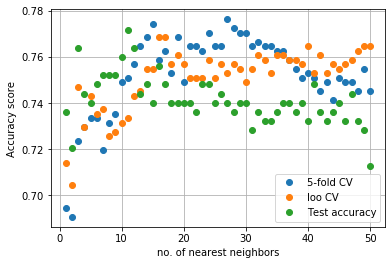

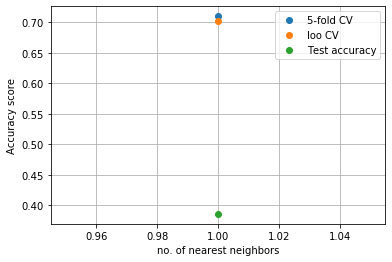

In [3]:
def k_nearest_neighbors(X, Xt, y, yt, max_num_neighbors):
    neighbors = np.arange(1, max_num_neighbors + 1, dtype=np.int32)
    score_vs_neighbors_5fold = np.zeros(max_num_neighbors)
    score_vs_neighbors_loo = np.zeros(max_num_neighbors)
    score_test_set = np.zeros(max_num_neighbors)

    for k in neighbors:
        clf = knn(n_neighbors=k)

        # 5 fold CV
        scores_this_k = cross_validate(clf, X, y, cv=5)["test_score"]
        score_vs_neighbors_5fold[k-1] = np.mean(scores_this_k)

        # Leave one out
        cv = LeaveOneOut().split(X, y)
        scores_this_k = cross_validate(clf, X, y, cv=cv)["test_score"]
        score_vs_neighbors_loo[k-1] = np.mean(scores_this_k)

        # Test score
        clf.fit(X, y)
        y_pred = clf.predict(Xt)
        score_test_set[k-1] = np.sum(y_pred == yt)/n_test

    plt.plot(neighbors, score_vs_neighbors_5fold, 'o', label="5-fold CV")
    plt.plot(neighbors, score_vs_neighbors_loo, 'o', label="loo CV")
    plt.plot(neighbors, score_test_set, 'o', label="Test accuracy")
    plt.xlabel("no. of nearest neighbors")
    plt.ylabel("Accuracy score")
    plt.legend()
    plt.grid()
    plt.show()
    
X = X_train.copy()
Xt = X_test.copy()
y = y_train.copy()
yt = y_test.copy()
k_nearest_neighbors(X, Xt, y, yt, 50)

X2 = X_train2.copy()
Xt2 = X_test2.copy()
y2 = y_train2.copy()
yt2 = y_test2.copy()
k_nearest_neighbors(X2, Xt2, y2, yt2, 1)

#### First data set
The test score reaches its best accuracy at 11 nearest neighbors. loo CV estimates the best accuracy at 17 neighbors and 5-fold CV esimates the best accuracy at 27 neighbors.

#### Second data set
Both 5-fold CV and loo CV is overly optimistic and estimate an accuracy score of $\approx 0.7$, whereas the test set achieves a score of less than 0.4.

## Generalized Additive Model with Subset Selection

In [15]:
def general_additive_model(X, Xt, y, yt, perm):

    splines = s(0)
    for i in range(1, X.shape[1]):
        splines += s(i)

    gam = LogisticGAM(splines)
    clf = gam.fit(X.values, y.values)

    X_temp = pd.DataFrame() # Start with empty models
    Xt_temp = pd.DataFrame() # Start with empty models
    predictor_list = list(X)

    for i in perm:
        X_temp[predictor_list[i]] = X[predictor_list[i]].copy() # build models by one predictor at a time
        Xt_temp[predictor_list[i]] = Xt[predictor_list[i]].copy() # build models by one predictor at a time
        gam = LogisticGAM(n_splines=10)
        clf = gam.fit(X_temp.values, y.values)
        y_pred = clf.predict(Xt_temp)
        acc = np.sum(yt == y_pred)/n_test
        print(" * Predictors:", end=" ")
        [print(feat, end=", ") for feat in list(X_temp)] # Print the name of all predictors included so far
        print(f"\n - Accuracy = {acc:1.2f}") # Print the test accuracy score for this model
        
        
# P values from lowest to largest: index 1, 5, 7, 4, 0, 6, 2, 3
print("Pima Indians Diabetes")
perm = [1, 5, 7, 4, 0, 6, 2, 3]
general_additive_model(X, Xt, y, yt, perm)

print("\nPima Indians Diabetes2")
X2 = X_train2.copy()
Xt2 = X_test2.copy()
y2 = y_train2.copy()
yt2 = y_test2.copy()
perm2 = [1, 7, 0, 4, 6, 3, 5, 2]
general_additive_model(X2, Xt2, y2, yt2, perm2)


Pima Indians Diabetes
 * Predictors: Glucose, 
 - Accuracy = 0.73
 * Predictors: Glucose, BMI, 
 - Accuracy = 0.77
 * Predictors: Glucose, BMI, Age, 
 - Accuracy = 0.78
 * Predictors: Glucose, BMI, Age, Insulin, 
 - Accuracy = 0.78
 * Predictors: Glucose, BMI, Age, Insulin, Pregnancies, 
 - Accuracy = 0.78
 * Predictors: Glucose, BMI, Age, Insulin, Pregnancies, DiabetesPedigreeFunction, 
 - Accuracy = 0.77
 * Predictors: Glucose, BMI, Age, Insulin, Pregnancies, DiabetesPedigreeFunction, BloodPressure, 
 - Accuracy = 0.78
 * Predictors: Glucose, BMI, Age, Insulin, Pregnancies, DiabetesPedigreeFunction, BloodPressure, SkinThickness, 
 - Accuracy = 0.77

Pima Indians Diabetes2
 * Predictors: Glucose, 
 - Accuracy = 0.40
 * Predictors: Glucose, Age, 
 - Accuracy = 0.39
 * Predictors: Glucose, Age, Pregnancies, 
 - Accuracy = 0.39
 * Predictors: Glucose, Age, Pregnancies, Insulin, 
 - Accuracy = 0.39
 * Predictors: Glucose, Age, Pregnancies, Insulin, DiabetesPedigreeFunction, 
 - Accuracy =

#### First data set
The subsets which includes 3,4,5 and 7 predictors with the lowest p-values: provide the highest accuracy scores of 0.78.
#### Second data set
All accuracy scores achieved are much worse than the first data set, the best score is achieved at the full model.

## Six Various Methods
* Classification tree
* Bagging (probability votes)
* Bagging (consensus votes)
* Random forest
* Neural network
* AdaBoost

All of these will be used to classify the outcome (diabetes=True/False). The methods will be evaluated by using accuracy scores.


In [16]:
def classifier_comparisson(X, Xt, y, yt): 
    clfs = [
        DecisionTreeClassifier, 
        BaggingClassifier,
        RandomForestClassifier, 
        MLPClassifier,
        AdaBoostClassifier
    ]

    clf_params = [
        {},
        {},
        {"n_estimators": 100},
        {"hidden_layer_sizes": (100, 66, 40, 25, 16), "max_iter": 10000},
        {}
    ]

    names = [
        "Decision Tree    ",
        "Bagging (prob.)  ",
        "Random Forest    ",
        "Neural Network   ",
        "AdaBoosting      "
    ]


    for clf, params, name in zip(clfs, clf_params, names):
        # Average over 10 runs:
        score = 0
        for i in range(10):
            model = clf( **params).fit(X, y)
            score += model.score(Xt, yt)/10
        # Print results:
        print(name, f": Test accuracy score = {score:1.3f}")

    # Voting classifier
    clf1 = DecisionTreeClassifier()
    clf2 = RandomForestClassifier(n_estimators=100)
    clf3 = AdaBoostClassifier()
    clf4 = LogisticRegression(solver='lbfgs')

    clf = VotingClassifier(estimators=[
        ('dt', clf1), 
        ('rf', clf2),
        ('ab', clf3),
        ('lr', clf4)
    ])

    clf.fit(X, y)
    score = clf.score(Xt, yt)
    print(f"Voting Classifier : Test accuracy score = {score:1.3f}")
    
    
print("Pima Indians Diabetes")
classifier_comparisson(X, Xt, y, yt)

print("\nPima Indians Diabetes2")  
classifier_comparisson(X2, Xt2, y2, yt2)

Pima Indians Diabetes
Decision Tree     : Test accuracy score = 0.673
Bagging (prob.)   : Test accuracy score = 0.742
Random Forest     : Test accuracy score = 0.759
Neural Network    : Test accuracy score = 0.713
AdaBoosting       : Test accuracy score = 0.709
Voting Classifier : Test accuracy score = 0.752

Pima Indians Diabetes2
Decision Tree     : Test accuracy score = 0.722
Bagging (prob.)   : Test accuracy score = 0.758
Random Forest     : Test accuracy score = 0.792
Neural Network    : Test accuracy score = 0.762
AdaBoosting       : Test accuracy score = 0.769
Voting Classifier : Test accuracy score = 0.777


## Method of Choice
Out of all the results, the ***Random Forest*** seems to provide the best accuracy score for the test set. This holds for both data sets. Therefore it seems like a strong method of choice for classification problems. 

## New, Fixed Data Set

The first data set contained missing values (0) which were simply interpreted as values=0. This might lead to a biased result, because the input data is wrong. These data points are removed in the second data set.

In all the codes above, I included runs for both data sets, so all results are shown. 

* kNN show a much worse result for the second data set (only k=1 included), the k-fold CV and loo CV shows estimated accuracy scores of roughly 0.7 as before, but the test set accuracy is less than 0.4.

* The GAM with splines and with subset selections shows slightly different results. Glucose is still the most important variable, but BMI significantly looses its second place in the first data set, all the way down to second **last** place in the second data set.
    * In the second data set, the best test accuracy (0.42) is obtained with the full model, but is still significantly worse than the first data set which obtained 0.78 for several of the reduced models.
    
* The six different machine learning models in exercise 2.3 performs surprisingly similar for the 1st. and 2nd. data set. Both methods achieves the best result with random forest classifier, and the second data set achieves the highest test accuracy score of 0.792 (first data set only achieved 0.759). This is surprising, given the worse performance shown in kNN and GAM with splines.

The second data set is considered to provide the most correct results, because missing data points are removed. The random forest classifier seemed to achieve the best results in terms of accuracy score.